In [2]:
#Simulate 3D distribution of stars
import gfc
from gfc import *
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import Angle
import pygaia.astrometry.vectorastrometry as pg
from pygaia.astrometry.vectorastrometry import phaseSpaceToAstrometry, sphericalToCartesian, normalTriad
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants
import scipy as sp
import copy as cp
from matplotlib import rc
rc('font',**{'family':'serif', 'serif':['Times']})
rc('text', usetex=True)

galtoicrs = CoordinateTransformation(Transformations.GAL2ICRS)
icrstogal = CoordinateTransformation(Transformations.ICRS2GAL)

Rmin = 1. ; Rmax = 500. #pc

K=2
N=1000
meanstep = 5.
sgm=1.
p = 0.

sgmrnd = 10.
vmaxrnd = 100.

wmin = 0.5 ; wmax=5 ; wstep=.25
Kmin=1 ; Kmax=10 ; Kstep=1

random = False
coordtransf = True #Do you want to include transformation from x,y,z to astrometry using astrometry as input for XD?

root_folder = "/disks/strw9/vanweenen/mrp1/results/test/"

if random == False:
    save_folder = root_folder + "chosen/"
else:
    save_folder = root_folder + "random/"


def simulate_x():
    """
    Generate homogeneous distribution in spherical coordinates for x
    Parameters
        phi (rad)
        theta (rad)
        r (pc)
    Return
        x (pc)
    """
    np.random.seed(1)
    phi = np.random.uniform(0, 2*np.pi, N)
    theta = np.arccos(np.random.uniform(-1, 1, N))
    r = np.random.uniform(Rmin**3, Rmax**3, N)**(1./3.) #pc
    x1,x2,x3 = pg.sphericalToCartesian(r, phi, theta)
    x = np.vstack((x1,x2,x3)).T
    return x

def simulate_chosen_amps(k):
    """
    Simulate chosen amps
    """
    #a = [amp1, amp2]
    a = np.tile([1./k],k)
    return a

def simulate_chosen_varying_amps(k):
    a = np.empty([k])
    rest = 1
    for i in range(k-1):
        a[i] = (1./k)/(i+2)**p
        rest = rest - a[i]
    a[k-1] = rest
    return a

def simulate_random_amps(k):
    """
    Generate pseudo-random amplitudes (the number of stars in each component K)
    Return
        amps_prob (no units)
    """
    np.random.seed(0)
    a = np.empty([k]) #these are the real amplitudes and should be used with xd
    rest = 1
    for i in range(k-1):
        a[i] = np.random.uniform(0,rest)
        rest = rest - a[i]
    a[k-1] = rest
    return a

def simulate_chosen_means(k):
    """
    Generate chosen means
    Based on fact that average velocity of star is 100 km/s
    Return
        means (km/s)
    """
    m = np.empty([k, 3])
    for i in range(k):
        m[i,:] = [meanstep*i, meanstep*i, meanstep*i]
    return m
    

def simulate_random_means(k):
    """
    Generate pseudo-random means, different for each component
    Based on fact that average velocity of star is 100 km/s
    Return
        means (km/s)
    """
    np.random.seed(2)
    m = np.empty([k, 3])
    m[:,0] = np.random.uniform(0.,vmaxrnd, k)
    m[:,1] = np.random.uniform(0.,vmaxrnd, k)
    m[:,2] = np.random.uniform(0.,vmaxrnd, k)
    return m

def simulate_chosen_sigma(k):
    var = np.tile([sgm**2,sgm**2,sgm**2], (k, 1))
    return var

def simulate_random_constant_sigma2(k):
    """
    Generate pseudo-random covariances that do not vary per component
    Return
        sigma2 (km/s)^2
    """
    np.random.seed(3)
    var = np.tile(np.random.uniform(0.,sgmrnd,3), (k,1))
    return var

def simulate_random_varying_sigma2(k):
    """
    Generate pseudo-random covariances, different for each component
    Return
        sigma2 (km/s)^2
    """
    np.random.seed(3)
    var = np.empty([k, 3])
    var[:,0] = np.random.uniform(0.,sgmrnd, k)
    var[:,1] = np.random.uniform(0.,sgmrnd, k)
    var[:,2] = np.random.uniform(0.,sgmrnd, k)
    return var
    
def sigma_to_cov(var,k):
    """
    Create covariance matrix of velocity distribution with sigma2
    Parameters
        sigma2 (km/s)^2
    Return
        covs (km/s)^2
    """
    c = np.zeros((k,3,3))
    c[:,0,0] = var[:,0]
    c[:,1,1] = var[:,1]
    c[:,2,2] = var[:,2]
    return c
      
def simulate_amc(vary_sigma2 = False, vary_amps = True):
    """
    Returns
        amps (fraction)
        means (km/s)
        covs (km/s)^2
    """
    print "Random = ", random
    if random == False:
        for k in range(Kmin, Kmax+1):
            if vary_amps:
                amps = simulate_chosen_varying_amps(k)
            else:
                amps = simulate_chosen_amps(k)
            means = simulate_chosen_means(k) #array of K by 3 means
            covs = sigma_to_cov(simulate_chosen_sigma(k),k)
            np.save(save_folder + '/initial_values/initial_amps_K{0}.npy'.format(k), amps)
            np.save(save_folder + '/initial_values/initial_means_K{0}.npy'.format(k), means)
            np.save(save_folder + '/initial_values/initial_covs_K{0}.npy'.format(k), covs)
            if k == K:
                amps_K = amps
                means_K = means
                covs_K = covs
    else:
        for k in range(Kmin, Kmax+1):
            amps = simulate_random_amps(k)
            means = simulate_random_means(k)
            if vary_sigma2:
                covs = sigma_to_cov(simulate_random_varying_sigma2(k),k)
            else:
                covs = sigma_to_cov(simulate_random_constant_sigma2(k),k)
            np.save(save_folder + '/initial_values/initial_amps_K{0}.npy'.format(k), amps)
            np.save(save_folder + '/initial_values/initial_means_K{0}.npy'.format(k), means)
            np.save(save_folder + '/initial_values/initial_covs_K{0}.npy'.format(k), covs)
            if k == K:
                amps_K = amps
                means_K = means
                covs_K = covs
    return amps_K, means_K, covs_K
    
def simulate_v(vary_sigma2 = False, vary_amps = True):
    """
    Generate normal distribution in Carthesian coordinates for velocity consisting of K components
    Parameters
        means (km/s)
        covs (km/s)^2
    Return
        v (km/s)
    """
    amps, means, covs = simulate_amc()
    v = np.empty([N,3])
    component = np.random.choice(K, N, p=amps) #choose component
    for i in range(N):
        v[i] = np.random.multivariate_normal(means[component[i],:], covs[component[i],:,:])
    return v, amps, means, covs

"""
Simulate homogeneous distribution for x in spherical coordinates
Simulate normal distribution for v consisting of K components
"""
#Carthesian coordinates: x (pc), v (km/s)
x = simulate_x() #in pc
v, amps_K, means_K, covs_K = simulate_v() #in km/s
vcov = np.zeros_like(v) #use this when not using astrometry coordinate transformation

print "amps", amps_K
print "means", means_K
print "covs", covs_K

sgm = round(np.average([np.sqrt(covs_K[0,0,0]), np.sqrt(covs_K[0,1,1]), np.sqrt(covs_K[0,2,2])]),1) #average sigma used

arr_phasespace = np.column_stack((x,v))
labels_phasespace = ('x1','x2','x3','v1','v2','v3')
t_phasespace = Table(arr_phasespace, names=labels_phasespace)

Random =  False
amps [ 0.5  0.5]
means [[ 0.  0.  0.]
 [ 5.  5.  5.]]
covs [[[ 1.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  1.]]

 [[ 1.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  1.]]]


In [3]:
# Transformation to astrometry coordinates
print "Transformation to astrometry coordinates.."
#phi (rad->mas), theta (rad->mas), parallax (mas), muphistar (mas/yr), mutheta (mas/yr), vrad (km/s)
x_icrs, y_icrs, z_icrs = galtoicrs.transformCartesianCoordinates(x[:,0], x[:,1], x[:,2])
u_icrs, v_icrs, w_icrs = galtoicrs.transformCartesianCoordinates(v[:,0], v[:,1], v[:,2])

phi, theta, parallax, muphistar, mutheta, vrad = pg.phaseSpaceToAstrometry(x_icrs, y_icrs, z_icrs, u_icrs, v_icrs, w_icrs)
phi = Angle(phi, u.radian)
theta = Angle(theta, u.radian)
astr_true = np.column_stack((phi.mas, theta.mas, parallax, muphistar, mutheta, vrad)) #leave v_rad out, true values

#Measurement errors and covariances: phi_error (mas), theta_error (mas), parallax_error(mas), muphistar_error (mas/yr), mutheta_error (mas/yr)
#Take 0.3 mas for parallax and 1 mas/yr for mustar and mutheta as true variances
errors_astr = np.array([0.,0.,0.3,1.,1.,0])
covs_astr = np.diag(errors_astr**2)

#Simulate measured values of astrometry
astr_measured = np.empty([N,6])
for i in range(N):
    astr_measured[i] = np.random.multivariate_normal(astr_true[i,:], covs_astr, 1)

corr_measured = np.tile(np.tile([0.],15), (N, 1)) #nondiagonal values of array
errors_measured = np.tile(errors_astr, (N,1))

#Make a table of data
arr_astr = np.column_stack((astr_measured, errors_measured, corr_measured))
labels = ('ra', 'dec', 'parallax', 'pmra', 'pmdec', 'vrad', 'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'vrad_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'ra_vrad_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'dec_vrad_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'parallax_vrad_corr', 'pmra_pmdec_corr', 'pmra_vrad_corr', 'pmdec_vrad_corr')
t_astr=Table(arr_astr, names=labels)
print t_astr

print "Projection.."

# Perform the projection
for i in ["ra", "dec"]:
    gfc.add_rad(t_astr,i)
print t_astr
matrix.transformation(t_astr, v_rad_col = 'vrad')
warr = gfc.XD_arr(t_astr, "w1", "w2", "w3")
wcov = gfc.XD_arr(t_astr, "S") ; wcov[:,0,0] = 1e15
proj = gfc.XD_arr(t_astr, "R")
uvwarr = gfc.XD_arr(t_astr, "U", "V", "W")

print "warr", warr
print "wcov", wcov
print "proj", proj

Transformation to astrometry coordinates..
      ra            dec          parallax   ... pmra_vrad_corr pmdec_vrad_corr
-------------- -------------- ------------- ... -------------- ---------------
-568334302.029  31399298.5326 2.61104516024 ...            0.0             0.0
 573945630.328 -45081047.5056 1.74259612024 ...            0.0             0.0
-510569577.371   31201010.577 2.56144629296 ...            0.0             0.0
-552420621.405  206247122.523 3.64851835377 ...            0.0             0.0
-614874555.245  93203274.5546 3.11946576448 ...            0.0             0.0
  555717044.71  77990212.4837 2.00727385778 ...            0.0             0.0
 506474640.239 -57676918.1576 2.11977393555 ...            0.0             0.0
 -599809058.27  22530693.7321 3.81391170798 ...            0.0             0.0
-517985417.091 -133328468.742 2.36132047367 ...            0.0             0.0
 601883411.214  115808146.699 3.04271449622 ...            0.0             0.0
         

In [4]:
# Find loglikelihood with XD and find AIC for different values of K and different values of w
print "Starting"
dim = 3.

wrange = np.arange(wmin, wmax + wstep, wstep)**2.
Krange = range(Kmin, Kmax + Kstep, Kstep)

logL = np.tile(np.nan, (len(Krange), len(wrange)))
AIC = np.tile(np.nan, (len(Krange), len(wrange)))
MDL = np.tile(np.nan, (len(Krange), len(wrange)))

print "XD.."

max_logL = -1e15
min_AIC = 1e15
min_MDL = 1e15

for k in Krange:
    init_amps = gfc.io.load(save_folder + "/initial_values/initial_amps_K{0}.npy".format(k))
    init_means = gfc.io.load(save_folder + "/initial_values/initial_means_K{0}.npy".format(k))
    init_covs = gfc.io.load(save_folder + "/initial_values/initial_covs_K{0}.npy".format(k))
    print k
    for W in xrange(len(wrange)):
        input_amps = cp.copy(init_amps) ; input_means = cp.copy(init_means) ; input_covs = cp.copy(init_covs)
        if coordtransf == True:
            amps_xd, means_xd, covs_xd, logL[k-1,W] = XD(warr, wcov, input_amps, input_means, input_covs, projection=proj, w=wrange[W]) #extreme deconvolution
        else:
            amps_xd, means_xd, covs_xd, logL[k-1,W] = XD(v, vcov, input_amps, input_means, input_covs, w=wrange[W]) #extreme deconvolution
        logL[k-1,W] *= N
        AIC[k-1,W] = -2./N*(N-1.-dim-Kmax/2.)*logL[k-1,W]+3*k*dim
        MDL[k-1,W] = -logL[k-1,W] + k*dim*np.log(N)/2.
        if logL[k-1,W] > max_logL:
            max_logL = logL[k-1,W]
            bestK_logL = k ; bestw_logL = wrange[W]
            amps_logL = amps_xd ; means_logL = means_xd ; covs_logL = covs_xd
        if AIC[k-1,W] < min_AIC:
            min_AIC = AIC[k-1,W]
            bestK_AIC = k ; bestw_AIC = wrange[W]
            amps_AIC = amps_xd ; means_AIC = means_xd ; covs_AIC = covs_xd
        if MDL[k-1,W] < min_MDL:
            min_MDL = MDL[k-1,W]
            bestK_MDL = k ; bestw_MDL = wrange[W]
            amps_MDL = amps_xd ; means_MDL = means_xd ; covs_MDL = covs_xd

print "Best values.."
print "logL: ", "best K = {0} ; best w = {1}".format(bestK_logL, bestw_logL)
print amps_logL, means_logL, covs_logL
print "AIC: ", "best K = {0} ; best w = {1}".format(bestK_AIC, bestw_AIC)
print amps_AIC, means_AIC, covs_AIC
print "MDL: ", "best K = {0} ; best w = {1}".format(bestK_MDL, bestw_MDL)
print amps_MDL, means_MDL, covs_MDL
print "Done"


Starting
XD..
1
2
3
4
5
6
7
8
9
10
Best values..
logL:  best K = 3 ; best w = 0.5625
[ 0.51027142  0.4877625   0.00196608] [[  4.85902929e+00   4.88365400e+00   4.87961111e+00]
 [ -5.84471404e-03   9.81856204e-02  -8.03390767e-02]
 [  1.02781956e+01   1.04095826e+01   3.60685235e+00]] [[[ 0.66632231 -0.14716617 -0.12759359]
  [-0.14716617  0.54280064 -0.0812038 ]
  [-0.12759359 -0.0812038   0.96617464]]

 [[ 0.62736233  0.01779597 -0.22369087]
  [ 0.01779597  0.6276002  -0.1617964 ]
  [-0.22369087 -0.1617964   0.78520888]]

 [[ 0.52459125  0.00897432  0.01340056]
  [ 0.00897432  0.52427303 -0.00921691]
  [ 0.01340056 -0.00921691  0.49720097]]]
AIC:  best K = 2 ; best w = 0.25
[ 0.51227548  0.48772452] [[ 4.87249973  4.89490361  4.86837464]
 [-0.00541687  0.09737432 -0.0804524 ]] [[[ 0.67744177 -0.12584034 -0.1645273 ]
  [-0.12584034  0.54745646 -0.11172253]
  [-0.1645273  -0.11172253  0.97561416]]

 [[ 0.61242676  0.01984159 -0.2270624 ]
  [ 0.01984159  0.61127022 -0.16251401]
  [-0.22

Saving figure..


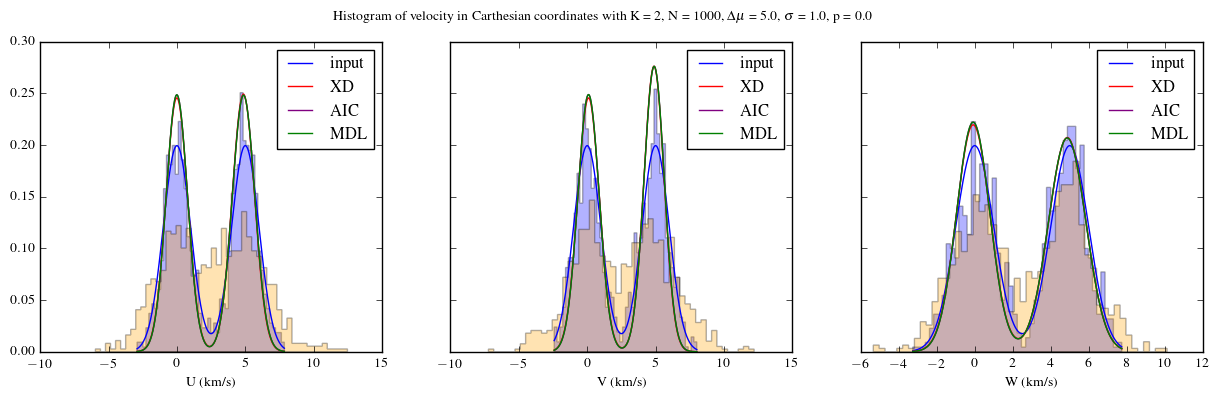

Done


In [5]:
# Plot output data

def hist_data(i, x, amps, means, covs, c, l):
    norm = np.zeros(len(x))
    for j in range(len(amps)):
        norm += amps[j]*sp.stats.norm.pdf(x, loc=means[j,i], scale=np.sqrt(covs[j,i,i]))
    ax[i].plot(x, norm, label=l, color=c, lw=1)

names = ['U', 'V', 'W']
unit = ' (km/s)'
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,4))
for i in range(0,3):
    x = np.linspace(np.amin(v[:,i]), np.amax(v[:,i]), N)
    hist_data(i, x, amps_K, means_K, covs_K, "blue", "input")
    hist_data(i, x, amps_logL, means_logL, covs_logL, "red", "XD")
    hist_data(i, x, amps_AIC, means_AIC, covs_AIC, "purple", "AIC")
    hist_data(i, x, amps_MDL, means_MDL, covs_MDL, "green", "MDL")
    ax[i].hist(v[:,i], bins=50, normed=True, facecolor='blue', histtype='stepfilled', alpha=0.3)
    ax[i].hist(uvwarr[:,i], bins=50, normed=True, facecolor='orange', histtype='stepfilled', alpha=0.3)
    ax[i].set_xlabel(names[i] + unit)
    ax[i].legend(loc="upper right")
plt.suptitle('Histogram of velocity in Carthesian coordinates with K = {0}, N = {1}, $\Delta\mu$ = {2}, $\sigma$ = {3}, p = {4}'.format(K,N,meanstep,sgm,p))
print "Saving figure.."
plt.savefig(save_folder + '/hist_velocity_K{0}_N{1}_mean{2}_sigma{3}_p{4}'.format(K,N,meanstep,sgm,p) + '.png')
plt.show()
print "Done"

Saving figure..


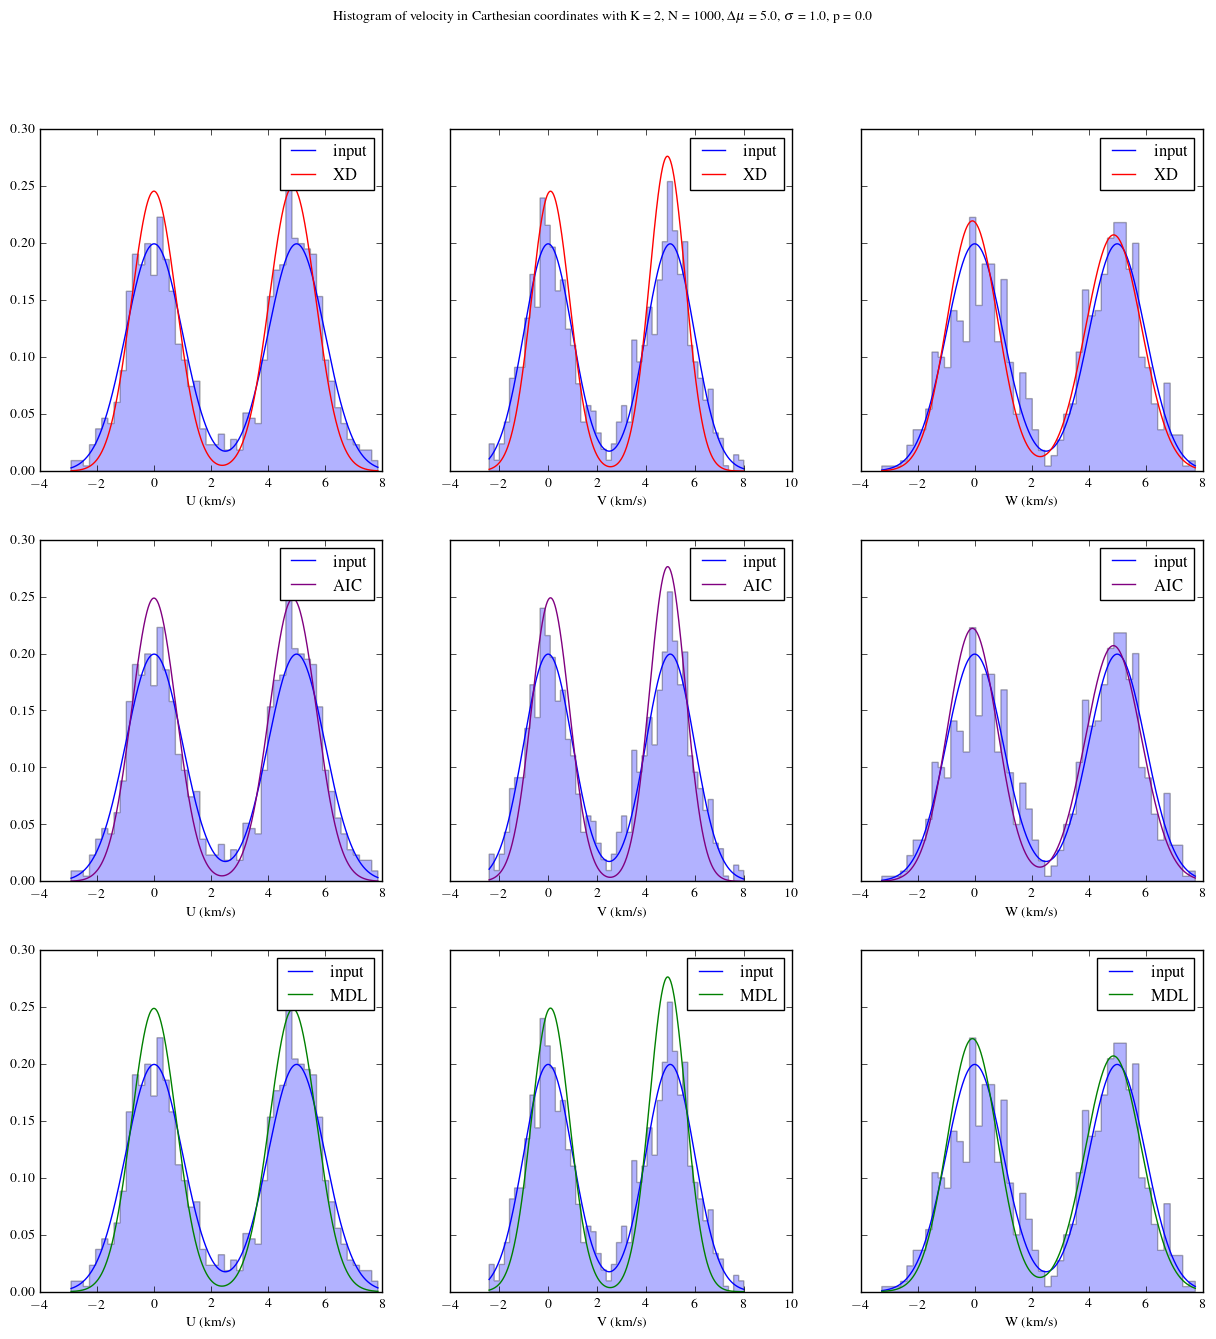

Done


In [6]:
# Plot output data

def hist_data(i,j, x, amps, means, covs, c, l):
    norm = np.zeros(len(x))
    for n in range(len(amps)):
        norm += amps[n]*sp.stats.norm.pdf(x, loc=means[n,j], scale=np.sqrt(covs[n,j,j]))
    ax[i,j].plot(x, norm, label=l, color=c, lw=1)

names = ('U', 'V', 'W')
unit = ' (km/s)'
labels = ("XD", "AIC", "MDL")
amps_test = (amps_logL, amps_AIC, amps_MDL)
means_test = (means_logL, means_AIC, means_MDL)
covs_test = (covs_logL, covs_AIC, covs_MDL)
colors = ("red", "purple", "green")
fig, ax = plt.subplots(len(amps_test),len(names),sharey=True,figsize=(15,15))
for i in range(len(amps_test)):
    for j in range(len(names)):
        x = np.linspace(np.amin(v[:,j]), np.amax(v[:,j]), N)
        hist_data(i,j, x, amps_K, means_K, covs_K, "blue", "input")
        hist_data(i,j, x, amps_test[i], means_test[i], covs_test[i], colors[i], labels[i])
        ax[i,j].hist(v[:,j], bins=50, normed=True, facecolor='blue', histtype='stepfilled', alpha=0.3)
        ax[i,j].set_xlabel(names[j] + unit)
        ax[i,j].legend(loc="upper right")
plt.suptitle('Histogram of velocity in Carthesian coordinates with K = {0}, N = {1}, $\Delta\mu$ = {2}, $\sigma$ = {3}, p = {4}'.format(K,N,meanstep,sgm,p))
print "Saving figure.."
plt.savefig(save_folder + '/hist3_velocity_XD_K{0}_N{1}_mean{2}_sigma{3}_p{4}'.format(K,N,meanstep,sgm,p) + '.png')
plt.show()
print "Done"

Starting
Saving figure..


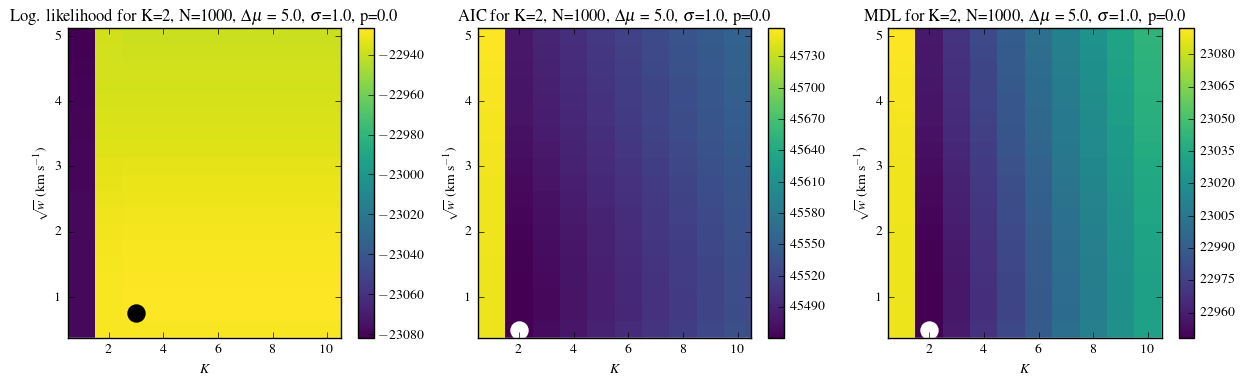

Done


In [7]:
# Plot log likelihood and AIC for different K and w
print "Starting"

title = ("Log. likelihood","AIC" ,"MDL")
test = (logL, AIC, MDL)
bestK = (bestK_logL, bestK_AIC, bestK_MDL)
bestw = (bestw_logL, bestw_AIC, bestw_MDL)
c = ("black", "white", "white")

fig, ax = plt.subplots(1,3,figsize=(15,4))
for i in range(3):
    ax[i].set_xlabel("$K$") ; ax[i].set_ylabel("$\sqrt{w}$ (km s$^{-1}$)")
    ax[i].set_xlim(Kmin-.5, Kmax+.5) ; ax[i].set_ylim(wmin-.125, wmax+.125)
    ax[i].set_title(title[i] + " for K={0}, N={1}, $\Delta\mu$ = {4}, $\sigma$={2}, p={3}".format(K,N,sgm,p,meanstep))
    ax[i].scatter(bestK[i], np.sqrt(bestw[i]), color=c[i], marker="o", s=150)
    im = ax[i].imshow(test[i].T, cmap=plt.cm.viridis, extent=(Kmin-.5, Kmax+.5, wmin-.125, wmax+.125), aspect='auto', interpolation='none', origin="lower")
    cbar = fig.colorbar(im, ax=ax[i], orientation="vertical")

print "Saving figure.."
plt.savefig(save_folder + '/logL-Kw_K{0}_N{1}_mean{4}_sigma{2}_p{3}'.format(K,N,sgm,p,meanstep) + '.png')
plt.show()
print "Done"
